<a href="https://colab.research.google.com/github/RXX17/Image-Processing/blob/main/ImageClassificationNasNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [4]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from typeguard import typechecked
from typing import Optional

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

Data Load and processing

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [11]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Split/train',
                                                   target_size = (331,331),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 732 images belonging to 4 classes.


In [12]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Split/train',
                                                  target_size = (331,331),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 181 images belonging to 4 classes.


In [13]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Split/val',
                                                  target_size = (331,331),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 231 images belonging to 4 classes.


Model Training

In [14]:
base_model = tf.keras.applications.NASNetLarge(input_shape=(331,331,3),include_top=False,weights="imagenet")

343610240/343610240 [==============================] - 2s 0us/step


In [15]:
# Freezing Layers

for layer in base_model.layers[:-3]:
    layer.trainable=False

In [16]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [17]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 11, 11, 4032)      84916818  
                                                                 
 dropout (Dropout)           (None, 11, 11, 4032)      0         
                                                                 
 flatten (Flatten)           (None, 487872)            0         
                                                                 
 batch_normalization (BatchN  (None, 487872)           1951488   
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                15611936  
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

In [18]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [19]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [20]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [21]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [22]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 5,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/5
12/12 [==============================] - 1280s 104s/step - loss: 1.5262 - accuracy: 0.7305 - precision: 0.3568 - recall: 0.0970 - auc: 0.5417 - f1_score: 0.1531 - val_loss: 6.5904 - val_accuracy: 0.6174 - val_precision: 0.2333 - val_recall: 0.2320 - val_auc: 0.4684 - val_f1_score: 0.2336 - lr: 0.0010
Epoch 2/5
12/12 [==============================] - 1170s 99s/step - loss: 1.3033 - accuracy: 0.7623 - precision: 0.5978 - recall: 0.1503 - auc: 0.6672 - f1_score: 0.2411 - val_loss: 2.7855 - val_accuracy: 0.7003 - val_precision: 0.3767 - val_recall: 0.3039 - val_auc: 0.5094 - val_f1_score: 0.3325 - lr: 0.0010
Epoch 3/5
12/12 [==============================] - 1210s 102s/step - loss: 1.1621 - accuracy: 0.7828 - precision: 0.7162 - recall: 0.2172 - auc: 0.7493 - f1_score: 0.3278 - val_loss: 1.7924 - val_accuracy: 0.7196 - val_precision: 0.4018 - val_recall: 0.2486 - val_auc: 0.6119 - val_f1_score: 0.3108 - lr: 0.0010
Epoch 4/5
12/12 [==============================] - 1187s 100s/ste

Plotting Data

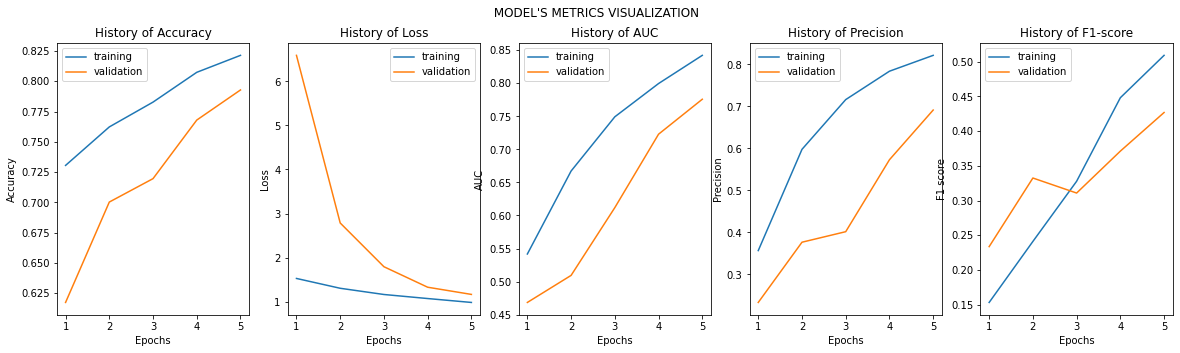

In [24]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])

plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )